In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [172]:
df = pd.read_pickle('files/preprosessed.pkl')

In [173]:
# We use the numpy fuction log1p which  applies log(1+x)
# to all elements of the column to fix skewed features
# Source: https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning

df["price.mainValue"] = np.log1p(df["price.mainValue"])


In [174]:
from scipy.stats import skew

numeric_feats = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna()))\
    .sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()


,Skewed Features
property.subtype_TRIPLEX,45.06662281427218630369679885916411876678466796...
Flood zone type_Possible circumscribed waterside zone,45.06662281427217209284208365716040134429931640...
property.location.postalCode_2030,45.06662281427213656570529565215110778808593750...
Flood zone type_context_property-page.circumscribed_flood_zone,45.06662281427159655322611797600984573364257812...
property.location.postalCode_2920,45.06662281427153260437989956699311733245849609...


In [175]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)
    df[feat] += 1

There are 104 skewed numerical features to Box Cox transform


In [176]:
from sklearn.model_selection import train_test_split
features =  list(df.drop(columns=['price.mainValue','id','Unnamed: 0.1'],axis=1))
X = df[features]
y = df['price.mainValue']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [178]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)
print('$',mean_absolute_error(y_test,dummy_predicts))

Model Accuracy: -0.43816629302797505
$ 0.038971581392239274


In [179]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [
          DecisionTreeRegressor(criterion='mse',max_depth=11),
          GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=0),
            RandomForestRegressor(min_samples_leaf =1, n_estimators=100,criterion='mse',max_depth=20,verbose=0)]
learning_mods = pd.DataFrame()
temp = {}

DecisionTreeRegressor(max_depth=11)
score on training 0.9478499812470625
r2 score 0.6178631713860823 

GradientBoostingRegressor(max_depth=12, n_estimators=200)
score on training 0.9999165959959918
r2 score 0.7551414875192932 

RandomForestRegressor(max_depth=20)
score on training 0.9721812045751208
r2 score 0.7964928344996616 



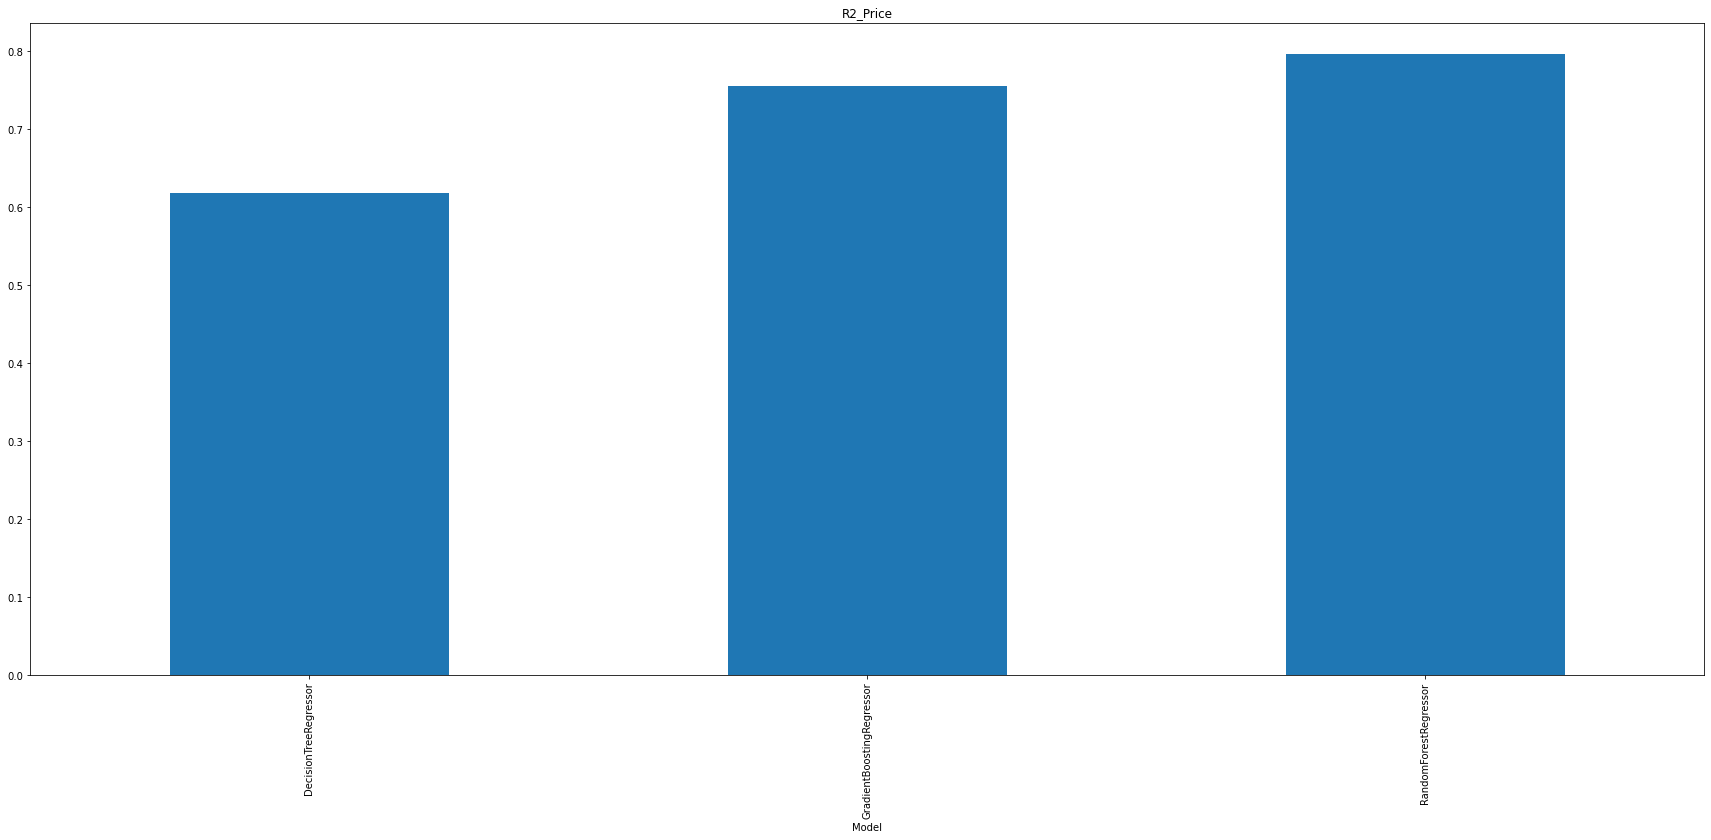

In [180]:
#run through models
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)),'\n')
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(30, 12))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

In [181]:
regressionTree_imp = model.feature_importances_

In [182]:
data_tuples = list(zip(features,regressionTree_imp.tolist()))
features_importance = pd.DataFrame(data_tuples, columns=['Feature','Value'])

In [183]:
print(len(features_importance))
unimportant_features = features_importance[features_importance['Value'] < .01]
features_importance = features_importance[features_importance['Value'] > .01]
print(len(features_importance))

101
12


In [184]:
features_importance = features_importance.sort_values(by=['Value'], ascending=False)
pd.set_option('display.float_format', lambda x: '%.1000f' % x)
features_importance

,Feature,Value
1,property.netHabitableSurface,0.606959220550611910915961288992548361420631408...
9,Living area,0.074736423175951999242627721287135500460863113...
58,property.location.postalCode_2000,0.058682190946057879998853934466751525178551673...
4,Construction year,0.030992726077554579033890291839270503260195255...
7,Energy class,0.019330853036271803541135128057248948607593774...
6,E-level (primary energy consumption),0.015129845405943686056926544836187531473115086...
18,Terrace surface,0.014377291048778190196699711123073939234018325...
13,Cadastral income,0.014210426237124158810321006285448675043880939...
0,property.bedroomCount,0.013958133838041071606017595740922843106091022...
10,Living room surface,0.012108215733625049895239023101112252334132790...


In [185]:
data_tuples = list(zip(y_test,model.predict(X_test)))
voorspellingen = pd.DataFrame(data_tuples, columns=['Echte Waarde','Voorspelling'])
voorspellingen['Voorspelling'] = voorspellingen['Voorspelling'].astype(int)

In [186]:
voorspellingen.astype(int)

,Echte Waarde,Voorspelling
0,4,4
1,4,4
2,4,4
3,4,4
4,4,4
...,...,...
402,4,4
403,4,4
404,4,4
405,4,4


In [187]:
list(features_importance['Feature'])

['property.netHabitableSurface',
 'Living area',
 'property.location.postalCode_2000',
 'Construction year',
 'Energy class',
 'E-level (primary energy consumption)',
 'Terrace surface',
 'Cadastral income',
 'property.bedroomCount',
 'Living room surface',
 'Bathrooms',
 'Number of floors']

In [188]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [189]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [190]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0,
                             learning_rate=0.05, max_depth=6,
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)

In [191]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0260 (0.0014)

ElasticNet score: 0.0258 (0.0014)

Kernel Ridge score: 0.0248 (0.0010)

Gradient Boosting score: 0.0230 (0.0012)

[00:36:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:36:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:36:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src

In [192]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [193]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.0234 (0.0012)



In [194]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [195]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: nan (nan)


/Users/inejj/anaconda3/envs/appartementen/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/inejj/anaconda3/envs/appartementen/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-194-6f2784eddcab>", line 20, in fit
    instance.fit(X[train_index], y[train_index])
  File "/Users/inejj/anaconda3/envs/appartementen/lib/python3.7/site-packages/pandas/core/series.py", line 910, in __getitem__
    return self._get_with(key)
  File "/Users/inejj/anaconda3/envs/appartementen/lib/python3.7/site-packages/pandas/core/series.py", line 943, in _get_with
    return self.loc[key]
  File "/Users/inejj/anaconda3/envs/appartementen/lib/python3.7/site-packages/pandas/core/indexing.py", line

In [196]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

[00:38:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
# Example
Stacked = 1/(0.1077)
XGBoost = 1/(0.1177)
Sum = Stacked + XGBoost
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
print(Stacked, XGBoost)

In [ ]:
ensemble = Stacked + xgb_pred*XGBoost


In [ ]:
sub = pd.DataFrame()
sub['SalePrice'] = ensemble
sub['True'] = y_test
sub.to_csv('submission.csv',index=False)

In [ ]:
len(y_test)